In [22]:
#!./env/bin/ python3

# Import modules
import datetime as dt
import numpy as np
import numpy_financial as npf
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

import modules.investingHelpers as investment

# Helpful
# https://www.youtube.com/watch?v=t_vZDyQDUkk

# To Do:
# - Plotting module
# - Money weighted ror -> converges to 0?

In [47]:
#end_date = dt.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - dt.timedelta(days=2)
end_date = dt.datetime(2025,1,6) # Year, month, day
start_date = dt.datetime(2021,7,9) # Year, month, day

# Calculate portfolio metrics
myPortfolio = investment.Portfolio()
myPortfolio.AddTransactions('./data/2024-12-31-History.tsv')
myPortfolio.TrackValue(start_date, end_date)

# Pull and process any additional data needed
sp500 = investment.Stock('^GSPC')
sp500.PullData(start_date, end_date, closure_buffer=0)
sp500.CalculateReturns()


1 Failed download:
- DWAC: No data found, symbol may be delisted


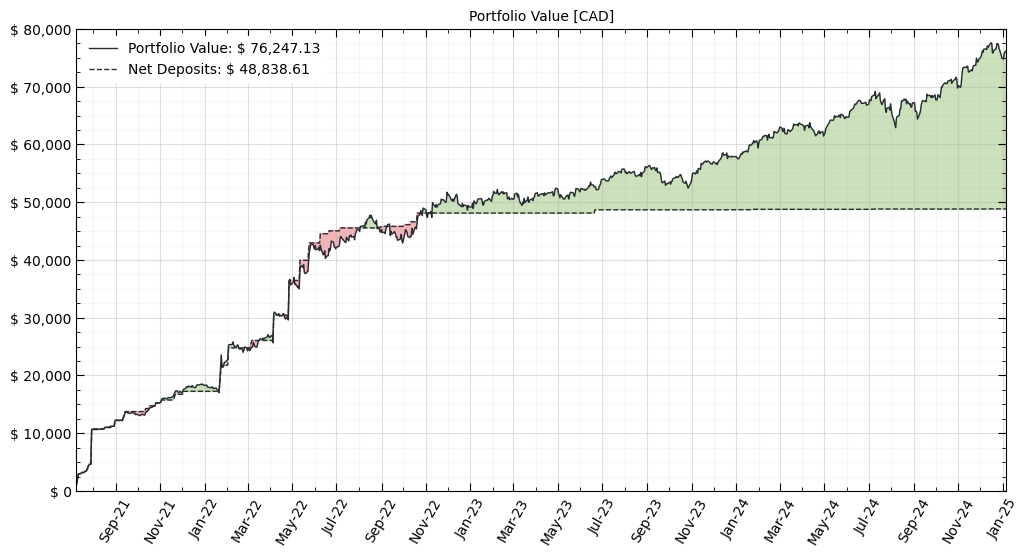

In [61]:
plot_colours = {'black':  '#282c34',
                'green':  '#98c379',
                'red':    '#e06c75',
                'yellow': '#e5c07b',
                'blue':   '#61afef',
                'purple': '#c678dd',
                'cyan':   '#56b6c2'}

# -----------------------------------------------------------------------------------
# Plot portfolio value over time

# Plotting parameters
y_min = 0
y_max = 80000
#y_ticks = np.linspace(y_min, y_max, int(((y_max-y_min)/10)+1))

fig, ax = plt.subplots(figsize=(12, 6))

# Plot
ax.plot(myPortfolio.dates, myPortfolio.value_history, '-', color=plot_colours['black'], linewidth=1,
        label='Portfolio Value: $ {:,.2f}'.format(myPortfolio.value_history[-1]))

#cumulative_deposits = np.cumsum(myPortfolio.deposit_history)
ax.plot(myPortfolio.dates, myPortfolio.cumulative_deposits, '--', color=plot_colours['black'], linewidth=1,
        label='Net Deposits: $ {:,.2f}'.format(myPortfolio.cumulative_deposits[-1]))

ax.fill_between(myPortfolio.dates, myPortfolio.value_history, myPortfolio.cumulative_deposits,
                where = myPortfolio.value_history >= myPortfolio.cumulative_deposits,
                color = plot_colours['green'], alpha = 0.5, interpolate=True)
ax.fill_between(myPortfolio.dates, myPortfolio.value_history, myPortfolio.cumulative_deposits,
                where = myPortfolio.value_history < myPortfolio.cumulative_deposits,
                color = plot_colours['red'], alpha = 0.5, interpolate=True)


# Format plot
plt.title('Portfolio Value [CAD]', fontsize=10)
#plt.xlabel('Date',fontsize=10, labelpad=10)
#plt.ylabel('Portfolio Value [CAD]', fontsize=10, labelpad=10)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
#ax.yaxis.set_major_formatter('$ {x:1.0f} K')
ax.yaxis.set_major_formatter('$ {x:1,.0f}')

plt.xticks(rotation = 60)
#plt.yticks(y_ticks)

# https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

#ax.xaxis.set_minor_locator(MonthLocator(bymonthday=[10,20], interval = 1))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_minor_locator(AutoMinorLocator(4))

ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='both', top=True, bottom=True,
               left=True, right=True, labelsize=10, length=6, direction='in')
ax.tick_params(axis='both', which='minor', top=True, bottom=True,
               left=True, right=True, length=3, direction='in')

plt.ylim([y_min,y_max])
plt.xlim([start_date, end_date])

plt.grid(which='major', alpha=0.4)
plt.grid(which='minor', alpha=0.1)
plt.tick_params(axis='both',labelsize=10)

legend = plt.legend(fontsize=10, loc='upper left', frameon=True, framealpha=1)
legend.get_frame().set_color('white')

plt.savefig('output/portfolio-value.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [49]:
print(myPortfolio.value_history[-5:-1])

[74913.90648541 74913.90648541 74770.15808925 75814.93123317]


In [50]:
date_to_check = dt.datetime(2025,1,6)

print(myPortfolio.stock_list)
print(myPortfolio.cash)

print('\n Exchange Rate')
print(myPortfolio.exchange_rates[date_to_check])
print('\n')

total_value = 0
for stock in myPortfolio.stock_list:
    print(stock)
    stock_value = stock.Value(date_to_check)
    if stock.ticker != 'VFV.TO':
        total_value += myPortfolio.exchange_rates[date_to_check] * stock_value
    else:
        print('CAD')
        total_value += stock_value

print(total_value + myPortfolio.cash['CAD'] + (myPortfolio.cash['USD'] * myPortfolio.exchange_rates[date_to_check]))

print('equity value')
print(total_value)

['10.0 units of AAPL', '6.0 units of MSFT', '41.0 units of QQQM', '222.0 units of VFV.TO', '3.0 units of META', '6.0 units of BRK-B', '9.0 units of COST', '4.0 units of VGT']
{'CAD': 8.750000000001023, 'USD': 123.60000000000218}

 Exchange Rate
1.444000005722046


AAPL
MSFT
QQQM
VFV.TO
CAD
META
BRK-B
COST
VGT
76247.12960521317
equity value
76059.90120450592


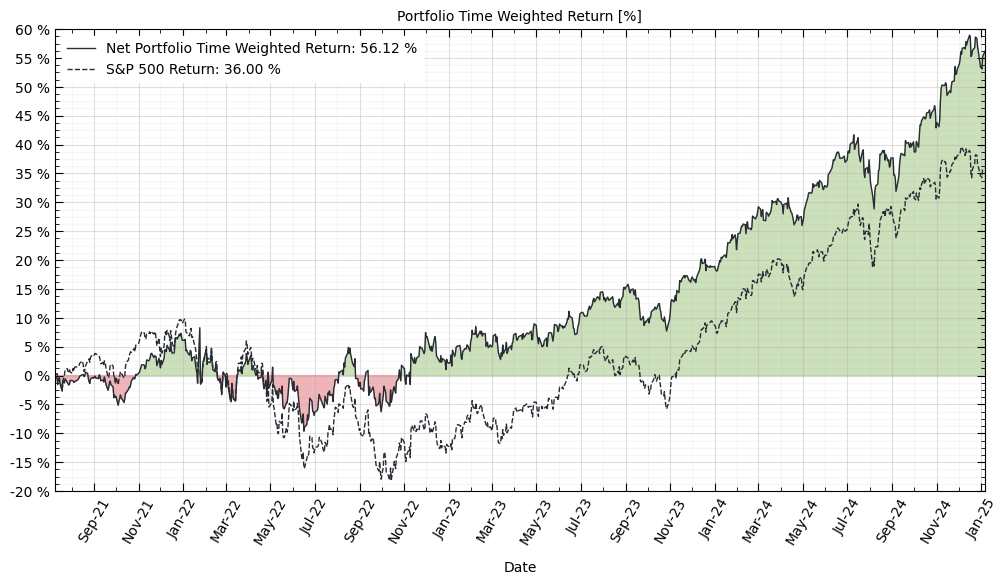

In [62]:
# -----------------------------------------------------------------------------------
# Plot portfolio % return over time

# Plotting parameters
y_min = -20
y_max = 60

fig, ax = plt.subplots(figsize=(12, 6))

# Plot
ax.plot(myPortfolio.dates, myPortfolio.time_weighted_ror, '-', color=plot_colours['black'], linewidth=1,
        label='Net Portfolio Time Weighted Return: {:,.2f} %'.format(myPortfolio.time_weighted_ror[-1]))

#ax.plot(myPortfolio.dates, cumulative_return_values, '-', color=plot_colours['blue'], linewidth=2,
#        label='Net Portfolio Time Weighted Return: {:,.2f} %'.format(cumulative_return_values[-1]))

ax.plot(sp500.close_prices.index, sp500.return_history, '--', color=plot_colours['black'], linewidth=1,
        label='S&P 500 Return: {:,.2f} %'.format(sp500.return_history[-1]))


#ax.plot(benchmark_data.index, benchmark_cumulative_returns, '-', color=plot_colours['red'], linewidth=2,
#        label='S&P 500 Return: {:,.2f} %'.format(benchmark_cumulative_returns[-1]))


ax.fill_between(myPortfolio.dates, 0, myPortfolio.time_weighted_ror,
                where = myPortfolio.time_weighted_ror >= 0,
                color = plot_colours['green'], alpha = 0.5, interpolate=True)
ax.fill_between(myPortfolio.dates, 0, myPortfolio.time_weighted_ror,
                where = myPortfolio.time_weighted_ror < 0,
                color = plot_colours['red'], alpha = 0.5, interpolate=True)


# Format plot
plt.title('Portfolio Time Weighted Return [%]', fontsize=10)
plt.xlabel('Date',fontsize=10, labelpad=10)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
#ax.yaxis.set_major_formatter('$ {x:1.0f} K')
ax.yaxis.set_major_formatter('{x:1,.0f} %')

plt.xticks(rotation = 60)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='both', top=True, bottom=True,
               left=True, right=True, labelsize=10, length=6, direction='in')
ax.tick_params(axis='both', which='minor', top=True, bottom=True,
               left=True, right=True, length=3, direction='in')

plt.ylim([y_min,y_max])
plt.xlim([start_date, end_date])

plt.grid(which='major', alpha=0.4)
plt.grid(which='minor', alpha=0.1)
plt.tick_params(axis='both',labelsize=10)

legend = plt.legend(fontsize=10, loc='upper left', frameon=True, framealpha=1)
legend.get_frame().set_color('white')

plt.savefig('output/percent-returns.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### Update README

In [65]:
md_file    = 'README.md'
final_date = end_date

# rewrite whole md file updating the summary lines
with open(md_file, 'r') as f:
    text     = f.readlines()
    new_text = ''

    i = 0
    while text[i] != '## Summary\n':
        new_text += text[i]
        i += 1
    
    new_text += '## Summary\n'
    new_text += 'Last Updated: ' + final_date.strftime('%b %d, %Y') + '\\\n'
    new_text += 'Total Portfolio Value:  $ {:1,.0f}\\\n'.format(myPortfolio.value_history[-1])
    new_text += 'Time Weighted Return: {:.2f}%\n'.format(myPortfolio.time_weighted_ror[-1])

    i += 4
    while i < len(text):
        new_text += text[i]
        i += 1

with open(md_file, 'w') as f:    
    f.write(new_text)

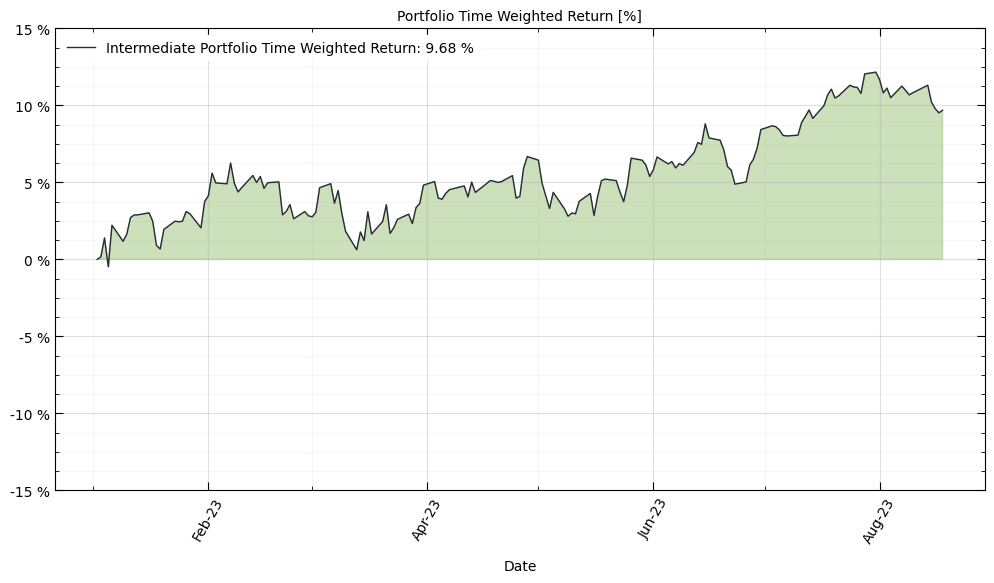

In [13]:
'''
Time weighted ror for a sub-interval
'''

intermediate_start_date = dt.datetime(2023, 1, 1)
intermediate_end_date   = dt.datetime(2023, 8, 20)

intermediate_returns = myPortfolio.TimeWeightedReturn(intermediate_start_date, intermediate_end_date)
intermediate_dates = investment.GetWeekdays(intermediate_start_date, intermediate_end_date)


# -----------------------------------------------------------------------------------
# Plot portfolio % return over time

# Plotting parameters
y_min = -15
y_max = 15

fig, ax = plt.subplots(figsize=(12, 6))

# Plot
ax.plot(intermediate_dates, intermediate_returns, '-', color=plot_colours['black'], linewidth=1,
        label='Intermediate Portfolio Time Weighted Return: {:,.2f} %'.format(intermediate_returns[-1]))

#ax.plot(sp500.close_prices.index, sp500.return_history, '--', color=plot_colours['black'], linewidth=1,
#        label='S&P 500 Return: {:,.2f} %'.format(sp500.return_history[-1]))

ax.fill_between(intermediate_dates, 0, intermediate_returns,
                where = intermediate_returns >= 0,
                color = plot_colours['green'], alpha = 0.5, interpolate=True)
ax.fill_between(intermediate_dates, 0, intermediate_returns,
                where = intermediate_returns < 0,
                color = plot_colours['red'], alpha = 0.5, interpolate=True)


# Format plot
plt.title('Portfolio Time Weighted Return [%]', fontsize=10)
plt.xlabel('Date',fontsize=10, labelpad=10)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
#ax.yaxis.set_major_formatter('$ {x:1.0f} K')
ax.yaxis.set_major_formatter('{x:1,.0f} %')

plt.xticks(rotation = 60)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='both', top=True, bottom=True,
               left=True, right=True, labelsize=10, length=6, direction='in')
ax.tick_params(axis='both', which='minor', top=True, bottom=True,
               left=True, right=True, length=3, direction='in')

plt.ylim([y_min,y_max])

plt.grid(which='major', alpha=0.4)
plt.grid(which='minor', alpha=0.1)
plt.tick_params(axis='both',labelsize=10)

legend = plt.legend(fontsize=10, loc='upper left', frameon=True, framealpha=1)
legend.get_frame().set_color('white')

plt.show()

0.0
0.018397098782352295


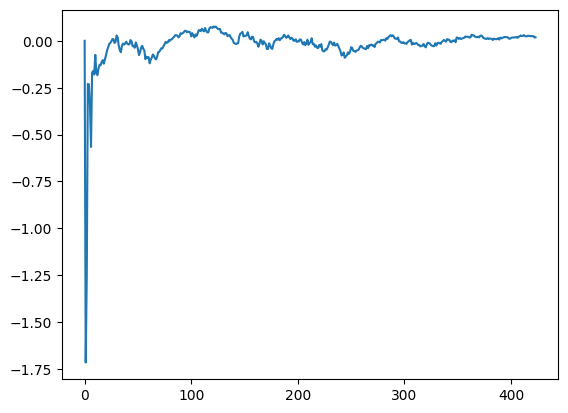

In [8]:
'''
Calculate MWRR

Looks like this approaches 0 the way I'm doing it
Maybe because I'm looking from the begining?
Can I look only at a single day? Then multiply all the days?
'''

values = np.array([1000, -1000])
sol = npf.irr(values)
print(sol)

#a = [1,2,3,4,5]
#print(a[0:0])
#
money_weighted_ror = np.zeros(len(myPortfolio.dates))
#k = 0
for i in np.arange(len(myPortfolio.dates)):
    #print('k='+str(k))
    cash_inflows = myPortfolio.deposit_history[0:i]
    final_value  = myPortfolio.value_history[i] - myPortfolio.deposit_history[i]
    #print(cash_inflows)
    #print(final_value)
    money_weighted_ror[i] = np.nan_to_num(npf.irr(np.append(cash_inflows, -final_value)))
    #print(money_weighted_ror[i])
    #k += 1
    #if k > 5: break

#print(money_weighted_ror[:20])
print(money_weighted_ror[-1] * 100)
plt.plot(money_weighted_ror * 100)
plt.show()

In [13]:
print(npf.irr([1000, 2000, -2982]) * 100)
print(npf.irr([1000, -982]) * 100)
print(npf.irr([100_000, 0, 10_000, 0, 0, 0, 0, 0, 0, 0, 0, -125_039]) * 100)
print(npf.irr([15_000, 10_000, 9_000, 4_000, -44_227.70]) * 100)
print(npf.irr([100, 118, -266]) * 100)

-0.4505073922762337
-1.7999999999999905
1.1913645536196116
5.235648177687002
14.438749995495526
[18840. 18871. 18901. 18932. 18962. 18993. 19024. 19052. 19083. 19113.
 19144. 19174. 19205. 19236. 19266. 19297. 19327. 19358. 19389.]


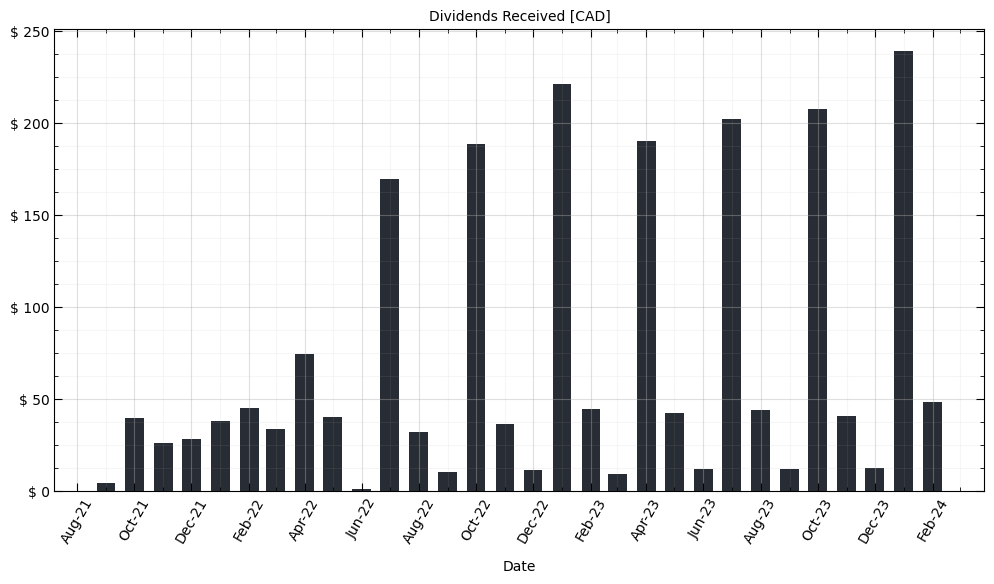

In [10]:
dividend_month_bins = pd.to_datetime(pd.date_range(start_date,end_date, 
                                freq='MS').tolist())

plt.close()
histogram = ax.hist(myPortfolio.dates, bins=dividend_month_bins, weights=myPortfolio.dividend_history,
                        color=plot_colours['black'], rwidth=0.75)

fig, ax = plt.subplots(figsize=(12, 6))

#ax.hist(myPortfolio.dates, bins=dividend_month_bins, weights=myPortfolio.dividend_history,
#        color=plot_colours['black'], rwidth=0.75)

offset = .4
ax.bar(histogram[1][1:], histogram[0], color=plot_colours['black'], width=20)
#ax.set_xticks(his[1][1:] + offset)
#ax.set_xticklabels( ('1', '2', '3', '4') )

# Format plot
plt.title('Dividends Received [CAD]', fontsize=10)
plt.xlabel('Date',fontsize=10, labelpad=10)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.xticks(rotation = 60)

ax.yaxis.set_major_formatter('$ {x:1,.0f}')
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='both', top=True, bottom=True,
               left=True, right=True, labelsize=10, length=6, direction='in')
ax.tick_params(axis='both', which='minor', top=True, bottom=True,
               left=True, right=True, length=3, direction='in')

plt.grid(which='major', alpha=0.4)
plt.grid(which='minor', alpha=0.1)
plt.tick_params(axis='both',labelsize=10)

#legend = plt.legend(fontsize=10, loc='upper left', frameon=True, framealpha=1)
#legend.get_frame().set_color('white')

plt.show()

In [5]:
myList = []

myList.append(investment.Stock('AAPL'))
myList.append(investment.Stock('MSFT'))
myList.append(investment.Stock('GOOGL'))

print(myList)
print([str(name) for name in myList])

# Get the stock we want to remove
stock = next((stock for stock in myList if stock.ticker == 'MSFT'), None)
if stock == None:
    raise Exception('Error: A stock with the ticker {} was not found in the stock list of this portfolio'.format('MSFT'))

myList.remove(stock)

print(myList)
print([str(name) for name in myList])

[<modules.investingHelpers.Stock object at 0x7f8895000130>, <modules.investingHelpers.Stock object at 0x7f8856e34c20>, <modules.investingHelpers.Stock object at 0x7f8856e78e00>]
['AAPL', 'MSFT', 'GOOGL']
[<modules.investingHelpers.Stock object at 0x7f8895000130>, <modules.investingHelpers.Stock object at 0x7f8856e78e00>]
['AAPL', 'GOOGL']


In [3]:
#print(myPortfolio.value_history)
#print(myPortfolio.stock_list)
#print(myPortfolio.cash)
print(len(myPortfolio.value_history))
print(len(myPortfolio.dates))
print(len(myPortfolio.deposit_history))
print(len(myPortfolio.dividend_history))
print(len(myPortfolio.return_history))

print(myPortfolio.return_history[:20])

281
281
281
281
281
[ 0.         -0.0057162  -0.01096866  0.01144964 -0.00238033 -0.00670296
 -0.01436864  0.01826812 -0.00101991 -0.00304497  0.00711572 -0.00770445
 -0.00249691  0.0012808   0.00058782 -0.00066825 -0.00032755 -0.00044878
 -0.002484    0.0007265 ]


In [2]:
ts = investment.TransactionReader('./data/Test_History.tsv')

print(ts.tickers)

['Cash' 'ZWC.TO' 'VDY.TO' 'Cash' 'Cash' 'Cash' 'Cash' 'Cash' 'AAPL' 'REVS'
 'Cash' 'Cash' 'LMT' 'Cash' 'POW.TO' 'TCEHY' 'Cash' 'NCLH' 'NCLH' 'Cash'
 'ENB.TO' 'T.TO' 'CU.TO' 'Cash' 'Cash' 'Cash' 'Cash' 'MFC.TO' 'Cash'
 'Cash' 'Cash' 'MFC.TO' 'CU.TO' 'T.TO' 'BCE.TO' 'POW.TO' 'MFC.TO' 'ENB.TO'
 'CU.TO' 'TRP.TO' 'TD.TO' 'CNR.TO' 'MFC.TO' 'TRP.TO' 'Cash' 'Cash' 'REVS'
 'TCEHY' 'BTI' 'AQN.TO' 'ZWC.TO' 'BTI' 'CU.TO' 'AQN.TO' 'CU.TO' 'BTI'
 'BTI' 'CU.TO' 'CLX' 'CLX' 'Cash' 'AQN.TO' 'BCE.TO' 'SU.TO' 'VDY.TO'
 'SU.TO' 'BCE.TO' 'BCE.TO' 'BCE.TO' 'CU.TO' 'CU.TO' 'CU.TO' 'AAPL'
 'TRP.TO' 'BTI']


In [10]:
transactions = np.genfromtxt('./data/Test_History.tsv', delimiter='\t', skip_header=2, autostrip=True, dtype=str)

print(transactions.shape)

print(transactions[:,0][:2])
#d = '07/12/2021'
d = transactions[:,0][:2]
#actual_date = dt.datetime(d)
actual_date = np.array([dt.datetime.strptime(t, '%m/%d/%Y').date() for t in d])

#actual_date = dt.datetime.strptime(d, '%m/%d/%Y')
print(actual_date)
print(type(actual_date))

print(actual_date[0])

# %m %d %y

(75, 10)
['07/09/2021' '07/12/2021']
[datetime.date(2021, 7, 9) datetime.date(2021, 7, 12)]
<class 'numpy.ndarray'>
2021-07-09


In [33]:
date_dict = dict.fromkeys(actual_date, [])

print(date_dict)

print(len(date_dict[actual_date[0]]))

{datetime.datetime(2021, 7, 9, 0, 0): [], datetime.datetime(2021, 7, 12, 0, 0): []}
0


In [3]:
end_date = dt.datetime.now()
start_date = dt.datetime(2023,2,2) # Year, month, day

investment.GetWeekdays(start_date, end_date)

array([datetime.datetime(2023, 2, 2, 0, 0),
       datetime.datetime(2023, 2, 3, 0, 0),
       datetime.datetime(2023, 2, 6, 0, 0),
       datetime.datetime(2023, 2, 7, 0, 0),
       datetime.datetime(2023, 2, 8, 0, 0),
       datetime.datetime(2023, 2, 9, 0, 0),
       datetime.datetime(2023, 2, 10, 0, 0),
       datetime.datetime(2023, 2, 13, 0, 0),
       datetime.datetime(2023, 2, 14, 0, 0),
       datetime.datetime(2023, 2, 15, 0, 0),
       datetime.datetime(2023, 2, 16, 0, 0),
       datetime.datetime(2023, 2, 17, 0, 0),
       datetime.datetime(2023, 2, 20, 0, 0),
       datetime.datetime(2023, 2, 21, 0, 0)], dtype=object)

In [12]:
# Choose a date range and pull data
end_date = dt.datetime.now()
start_date = dt.datetime(2020,1,1) # Year, month, day

stock_list = ['VFV.TO']

yf.pdr_override()
df = pdr.get_data_yahoo(stock_list, start_date, end_date, progress=False)
print(type(df.iloc[:, [4]]))
#close = df.Close
#print(type(close))

#df.head()
#print(df.shape)
#df.head()

<class 'pandas.core.frame.DataFrame'>


In [2]:
end_date = dt.datetime.now()
start_date = dt.datetime(2020,1,1) # Year, month, day

myStock = Stock('Apple', 'AAPL')

myStock.PullData(start_date, end_date)

myStock.Buy(5)

print(myStock.units)
#myStock.close_prices
print(myStock)

5
Apple (AAPL)


In [4]:
# Try to access exchagne rate data

end_date = dt.datetime.now()
start_date = dt.datetime(2020,1,1)

myExchange = investment.Stock('USDCAD=X')

print(myExchange)

myExchange.PullData(start_date, end_date)

print(myExchange.close_prices)
print(type(myExchange.close_prices))
print(type(myExchange.close_prices[0]))
print(myExchange.close_prices[0])
print(myExchange.close_prices.keys)
print(myExchange.close_prices[dt.datetime(2023,2,16)])
#print(myExchange.close_prices[dt.datetime(2023,2,16)])
#print(myExchange.close_prices[str(dt.datetime(2023,2,16))])
print(myExchange.close_prices.keys()[0])

USDCAD=X
Date
2020-01-01    1.30020
2020-01-02    1.29730
2020-01-03    1.29830
2020-01-06    1.29866
2020-01-07    1.29639
               ...   
2023-02-14    1.33331
2023-02-15    1.33406
2023-02-16    1.33906
2023-02-17    1.34730
2023-02-20    1.34820
Name: Adj Close, Length: 819, dtype: float64
<class 'pandas.core.series.Series'>
<class 'numpy.float64'>
1.3001999855041504
<bound method Series.keys of Date
2020-01-01    1.30020
2020-01-02    1.29730
2020-01-03    1.29830
2020-01-06    1.29866
2020-01-07    1.29639
               ...   
2023-02-14    1.33331
2023-02-15    1.33406
2023-02-16    1.33906
2023-02-17    1.34730
2023-02-20    1.34820
Name: Adj Close, Length: 819, dtype: float64>
1.3390599489212036
2020-01-01 00:00:00


In [19]:
msft = yf.Ticker('VFV.TO')
name = msft.info['longName']
print(name)

Vanguard S&P 500 Index ETF


In [4]:
# Choose a date range and pull data
end_date = dt.datetime.now()
start_date = dt.datetime(2020,1,1) # Year, month, day

myPortfolio = Portfolio()

myPortfolio.AddStock('MSFT')
myPortfolio.AddStock('AAPL')
myPortfolio.AddStock('VFV.TO')

for stock in myPortfolio.stock_list:
    stock.PullData(start_date, end_date)

print([str(stock) for stock in myPortfolio.stock_list])

#stock = next((stock for stock in myPortfolio.stock_list if stock.ticker == 'Joe'), None)
print(stock)

['MSFT', 'AAPL', 'VFV.TO']
None
